In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations


from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [2]:
df_sinnull=pd.read_csv("..\..\..\datos\datos1\datos_clusterizados1_sin_nulos.csv", index_col=0)


In [3]:
df_sinnull.head(2)

,Ship Mode,Segment,City,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario
0,Same Day,Consumer,New York City,Technology,Accessories,entre 7 y 8,0.00,Critical,July,307.95
1,First Class,Consumer,Chicago,Technology,Phones,entre 5 y 6,0.20,High,October,497.45


In [4]:
df_sinnull.duplicated().sum()

0

In [5]:
df_sinnull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4535 entries, 0 to 4534
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Ship Mode       4535 non-null   object 
 1   Segment         4535 non-null   object 
 2   City            4535 non-null   object 
 3   Category        4535 non-null   object 
 4   Sub-Category    4535 non-null   object 
 5   Quantity        4535 non-null   object 
 6   Discount        4535 non-null   float64
 7   Order Priority  4535 non-null   object 
 8   month           4535 non-null   object 
 9   Sales_unitario  4535 non-null   float64
dtypes: float64(2), object(8)
memory usage: 389.7+ KB


Tenemos 8 columnas de categóricas

In [6]:
df_sinnull.nunique()

Ship Mode            4
Segment              3
City                12
Category             3
Sub-Category        17
Quantity             8
Discount            11
Order Priority       4
month               12
Sales_unitario    3390
dtype: int64

In [9]:
df_categoricas=df_sinnull.select_dtypes("O")

In [10]:
df_categoricas.head()

,Ship Mode,Segment,City,Category,Sub-Category,Quantity,Order Priority,month
0,Same Day,Consumer,New York City,Technology,Accessories,entre 7 y 8,Critical,July
1,First Class,Consumer,Chicago,Technology,Phones,entre 5 y 6,High,October
2,First Class,Home Office,Los Angeles,Technology,Phones,entre 7 y 8,High,March
3,Same Day,Consumer,New York City,Technology,Machines,entre 3 y 4,High,September
4,First Class,Consumer,New York City,Office Supplies,Binders,entre 3 y 4,High,June


Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

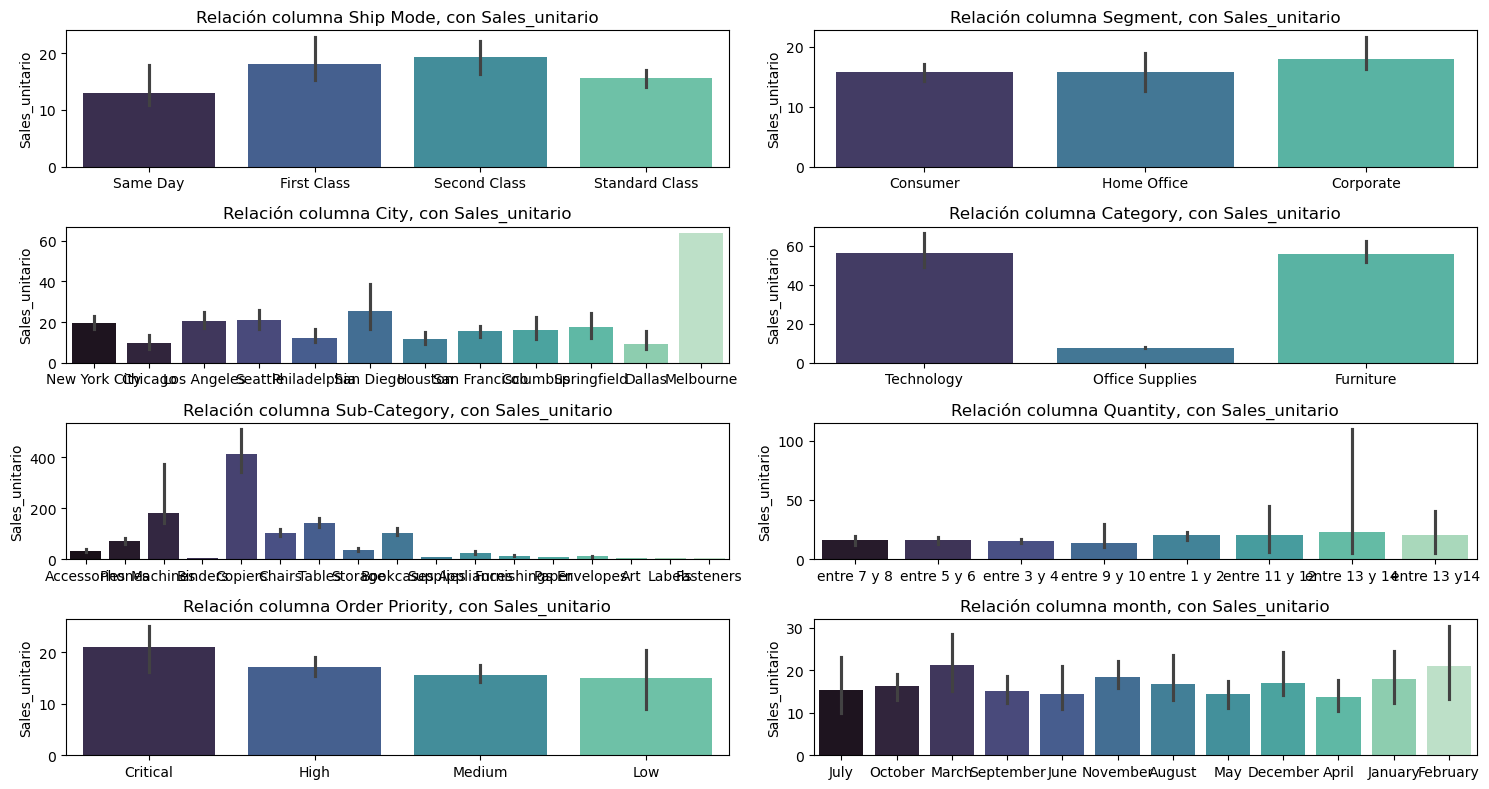

In [11]:
f.visualizar_categoricas(df_sinnull, "Sales_unitario", (15,8), tipo_graf="bar", bigote=1.5, metrica="median")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

In [12]:
# llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
asunciones = f.Asunciones(dataframe = df_sinnull, columna_numerica= "Sales_unitario")
print("\n-------------\n")
lista_col_categ=df_sinnull.select_dtypes(include="O")

for categoria in lista_col_categ:   

    print(f"Estamos analizando la variable {categoria.upper()}")
    
    asunciones.identificar_normalidad(metodo = "kolmogorov") 

    # comprobamos la homogeneidad de varianzas
    asunciones.identificar_homogeneidad(columna_categorica = categoria)

    # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
    test = f.TestEstadisticos(df_sinnull, "Sales_unitario", categoria)
    test.run_all_tests()
    print("\n###########################\n")


-------------

Estamos analizando la variable SHIP MODE
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Ship Mode las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Same Day', 'First Class', 'Second Class', 'Standard Class']

Realizando test de Kruskal...
Estadístico de prueba: 5.916871768762471
Valor p: 0.11572538500145596
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-16.64,0.48,-46.63,13.34,First Class-Same Day
1,-20.07,0.06,-40.48,0.35,First Class-Second Class
2,-25.38,0.00,-42.46,-8.30,First Class-Standard Class
3,-3.42,0.99,-32.58,25.73,Same Day-Second Class
4,-8.74,0.84,-35.66,18.18,Same Day-Standard Class
5,-5.32,0.82,-20.89,10.26,Second Class-Standard Class



###########################

Estamos analizando la variable SEGMENT
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Segment las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Consumer', 'Home Office', 'Corporate']

Realizando test de Kruskal...
Estadístico de prueba: 4.1021036365373655
Valor p: 0.12859956905053976
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,2.81,0.86,-9.62,15.24,Consumer-Corporate
1,7.08,0.51,-7.91,22.07,Consumer-Home Office
2,4.27,0.81,-12.05,20.59,Corporate-Home Office



###########################

Estamos analizando la variable CITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable City las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['New York City', 'Chicago', 'Los Angeles', 'Seattle', 'Philadelphia', 'San Diego', 'Houston', 'San Francisco', 'Columbus', 'Springfield', 'Dallas', 'Melbourne']

Realizando test de Kruskal...
Estadístico de prueba: 100.3260062725212
Valor p: 1.5391407169144319e-16
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,3.08,1.00,-41.64,47.80,Chicago-Columbus
1,-6.31,1.00,-56.09,43.47,Chicago-Dallas
2,-3.28,1.00,-42.19,35.63,Chicago-Houston
3,16.65,0.91,-17.62,50.92,Chicago-Los Angeles
4,17.31,1.00,-492.77,527.38,Chicago-Melbourne
...,...,...,...,...,...
61,3.75,1.00,-42.41,49.92,San Diego-Seattle
62,-11.19,1.00,-67.02,44.64,San Diego-Springfield
63,12.13,0.99,-21.26,45.51,San Francisco-Seattle
64,-2.82,1.00,-48.64,43.00,San Francisco-Springfield



###########################

Estamos analizando la variable CATEGORY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Technology', 'Office Supplies', 'Furniture']

Realizando test de Kruskal...
Estadístico de prueba: 1171.9241190803234
Valor p: 3.3106322171810965e-255
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-61.58,0.00,-74.87,-48.29,Furniture-Office Supplies
1,39.68,0.00,23.07,56.28,Furniture-Technology
2,101.26,0.00,87.45,115.06,Office Supplies-Technology



###########################

Estamos analizando la variable SUB-CATEGORY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Sub-Category las varianzas NO son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Accessories', 'Phones', 'Machines', 'Binders', 'Copiers', 'Chairs', 'Tables', 'Storage', 'Bookcases', 'Supplies', 'Appliances', 'Furnishings', 'Paper', 'Envelopes', 'Art', 'Labels', 'Fasteners']

Realizando test de Kruskal...
Estadístico de prueba: 2340.2338938024523
Valor p: 0.0
Hay una diferencia significativa entre los grupos
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-6.19,1.00,-46.38,34.00,Accessories-Appliances
1,-53.00,0.00,-87.73,-18.28,Accessories-Art
2,-30.39,0.04,-60.36,-0.42,Accessories-Binders
3,84.28,0.00,34.49,134.07,Accessories-Bookcases
4,79.89,0.00,42.98,116.80,Accessories-Chairs
...,...,...,...,...,...
131,-25.00,0.97,-78.43,28.43,Phones-Supplies
132,53.29,0.00,8.93,97.64,Phones-Tables
133,9.08,1.00,-44.46,62.63,Storage-Supplies
134,87.37,0.00,42.88,131.86,Storage-Tables



###########################

Estamos analizando la variable QUANTITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Quantity las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['entre 7 y 8', 'entre 5 y 6', 'entre 3 y 4', 'entre 9 y 10', 'entre 1 y 2', 'entre 11 y 12', 'entre 13 y 14', 'entre 13 y14']

Realizando test de Kruskal...
Estadístico de prueba: 13.308227775875423
Valor p: 0.06494521995563214
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-13.85,1.00,-101.15,73.45,entre 1 y 2-entre 11 y 12
1,-10.24,1.00,-147.46,126.98,entre 1 y 2-entre 13 y 14
2,-38.30,0.98,-161.15,84.56,entre 1 y 2-entre 13 y14
3,-7.49,0.88,-24.32,9.34,entre 1 y 2-entre 3 y 4
4,-8.58,0.92,-29.33,12.18,entre 1 y 2-entre 5 y 6
5,-11.27,0.92,-39.04,16.51,entre 1 y 2-entre 7 y 8
6,-18.55,0.86,-59.08,21.99,entre 1 y 2-entre 9 y 10
7,3.61,1.00,-158.10,165.33,entre 11 y 12-entre 13 y 14
8,-24.44,1.00,-174.17,125.28,entre 11 y 12-entre 13 y14
9,6.36,1.00,-80.86,93.58,entre 11 y 12-entre 3 y 4



###########################

Estamos analizando la variable ORDER PRIORITY
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable Order Priority las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['Critical', 'High', 'Medium', 'Low']

Realizando test de Kruskal...
Estadístico de prueba: 7.386493297953389
Valor p: 0.0605477820608123
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,-7.78,0.84,-32.07,16.51,Critical-High
1,-24.99,0.29,-61.25,11.26,Critical-Low
2,-11.13,0.61,-34.32,12.07,Critical-Medium
3,-17.21,0.48,-48.07,13.64,High-Low
4,-3.34,0.92,-16.61,9.92,High-Medium
5,13.87,0.63,-16.14,43.87,Low-Medium



###########################

Estamos analizando la variable MONTH
Para la columna Sales_unitario, los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov.
En la variable month las varianzas son homogéneas entre grupos.
Generando grupos...
Grupos generados: ['July', 'October', 'March', 'September', 'June', 'November', 'August', 'May', 'December', 'April', 'January', 'February']

Realizando test de Kruskal...
Estadístico de prueba: 9.458266870703694
Valor p: 0.5796702313956765
No hay evidencia suficiente para concluir que hay una diferencia significativa.
Los resultados del test de Tukey son: 



,meandiff,p-adj,lower,upper,group_diff
0,5.19,1.00,-34.86,45.23,April-August
1,2.78,1.00,-32.80,38.35,April-December
2,-13.19,1.00,-65.62,39.24,April-February
3,3.46,1.00,-49.24,56.16,April-January
4,8.59,1.00,-31.84,49.02,April-July
...,...,...,...,...,...
61,0.46,1.00,-38.76,39.68,May-October
62,11.63,0.99,-22.66,45.92,May-September
63,-9.03,1.00,-42.58,24.53,November-October
64,2.14,1.00,-25.48,29.77,November-September



###########################



#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- SHIP MODE
- SEGMENT
- QUANTITY
- ORDER PRIORITY
- MONTH  
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- SUB-CATEGORY (entre casi todas)
- CITY  (entre algunas)
- CATEGORY  (entre todas)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [14]:
df_sinnull.columns

Index(['Ship Mode', 'Segment', 'City', 'Category', 'Sub-Category', 'Quantity',
       'Discount', 'Order Priority', 'month', 'Sales_unitario'],
      dtype='object')

In [15]:
diccionario_encoding = {"onehot": ['Ship Mode', 'Segment','Quantity','Order Priority', 'month'], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ['City','Category', 'Sub-Category']  
                        }

In [16]:
df_sinnull.shape

(4535, 10)

In [17]:
encoding=f.Encoding(dataframe = df_sinnull , diccionario_encoding= diccionario_encoding, variable_respuesta= "Sales_unitario")
df_sinnull= encoding.one_hot_encoding()
df_sinnull.head()
#nos genera 31 columnas nuevas aproximadamente

,Ship Mode,Segment,City,Category,Sub-Category,Quantity,Discount,Order Priority,month,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,Same Day,Consumer,New York City,Technology,Accessories,entre 7 y 8,0.00,Critical,July,307.95,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,First Class,Consumer,Chicago,Technology,Phones,entre 5 y 6,0.20,High,October,497.45,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,First Class,Home Office,Los Angeles,Technology,Phones,entre 7 y 8,0.20,High,March,554.52,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,Same Day,Consumer,New York City,Technology,Machines,entre 3 y 4,0.00,High,September,799.99,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,First Class,Consumer,New York City,Office Supplies,Binders,entre 3 y 4,0.20,High,June,871.54,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [18]:
df_sinnull.shape

(4535, 41)

In [19]:
encoder_target= TargetEncoder(cols=['City','Category', 'Sub-Category'])
encoded= encoder_target.fit_transform(df_sinnull , df_sinnull[["Sales_unitario"]])
lista_eliminar=['Ship Mode', 'Segment','Quantity','Order Priority', 'month']
encoded.drop(columns=lista_eliminar, inplace=True)


In [20]:
encoded.head(2)

,City,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,79.91,131.79,61.41,0.00,307.95,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,46.44,131.79,102.44,0.20,497.45,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [21]:
encoded.columns

Index(['City', 'Category', 'Sub-Category', 'Discount', 'Sales_unitario',
       'Ship Mode_First Class', 'Ship Mode_Same Day', 'Ship Mode_Second Class',
       'Ship Mode_Standard Class', 'Segment_Consumer', 'Segment_Corporate',
       'Segment_Home Office', 'Quantity_entre 1 y 2', 'Quantity_entre 11 y 12',
       'Quantity_entre 13 y 14', 'Quantity_entre 13 y14',
       'Quantity_entre 3 y 4', 'Quantity_entre 5 y 6', 'Quantity_entre 7 y 8',
       'Quantity_entre 9 y 10', 'Order Priority_Critical',
       'Order Priority_High', 'Order Priority_Low', 'Order Priority_Medium',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

In [22]:
encoded.head()

,City,Category,Sub-Category,Discount,Sales_unitario,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Quantity_entre 1 y 2,Quantity_entre 11 y 12,Quantity_entre 13 y 14,Quantity_entre 13 y14,Quantity_entre 3 y 4,Quantity_entre 5 y 6,Quantity_entre 7 y 8,Quantity_entre 9 y 10,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,79.91,131.79,61.41,0.00,307.95,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
1,46.44,131.79,102.44,0.20,497.45,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,63.09,131.79,102.44,0.20,554.52,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,79.91,131.79,448.53,0.00,799.99,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,79.91,30.53,31.02,0.20,871.54,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [23]:
encoded.to_csv("..\..\..\datos\datos1\datos_clusterizados1_encoded.csv")